In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Compare MWPotential2014 to a similar potential that has a triaxial halo
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
# import glob
# import subprocess

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Project-specific
# Add the /src directory to the Python path and pull

In [3]:
%matplotlib inline

# Compare potentials
We will compare MWPotential2014 with a potential that has the same disk and bulge but a TriaxialNFWPotential. First get all of the parameters of MWPotential2014

In [4]:
# Get MWPotential2014, unpack the component potentials, and save copies
mwpot = potential.MWPotential2014
mwbulge = copy.deepcopy(mwpot[0])
mwdisk = copy.deepcopy(mwpot[1])
mwhalo = copy.deepcopy(mwpot[2])

### Explore a range in c: the ratio of the vertical to primary scale lengths

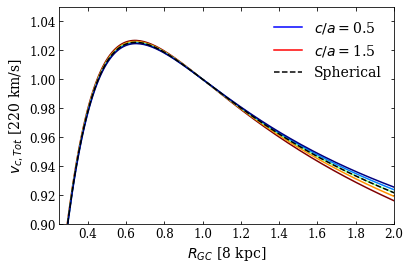

In [18]:
# Declare the range of c to explore
c_range = np.array([0.5,0.75,1.0,1.25,1.5])

# Start the figure
fig = plt.figure()
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet')

# Loop over the values of c
for i in range(len(c_range)):
    
    # Declare the triaxial NFW
    tripot_halo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                                 a=mwhalo.a,
                                                 b=1.0,
                                                 c=c_range[i],
                                                 normalize=0.35)
    tripot = [tripot_halo,mwbulge,mwdisk]
    
    # Plot the rotation curve
    norm_val = (np.max(c_range)-c_range[i])/(np.max(c_range)-np.min(c_range))
    potential.plotRotcurve(tripot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color=cmap(norm_val))
###i

# Plot the MWPotential2014 rotation curve
potential.plotRotcurve(mwpot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color='Black', 
                       linestyle='dashed')

ax.plot([], [], c='Blue', label=r'$c/a=$'+str(np.min(c_range)))
ax.plot([], [], c='Red', label=r'$c/a=$'+str(np.max(c_range)))
ax.plot([], [], c='Black', linestyle='dashed', label=r'Spherical')
leg = ax.legend(loc='upper right', frameon=False, fontsize=14)

ax.set_xlim(0.25,2.0)
ax.set_ylim(0.9,1.05)
ax.set_ylabel(r'$v_{c,Tot}$ [220 km/s]', fontsize=14)
ax.set_xlabel(r'$R_{GC}$ [8 kpc]', fontsize=14)
ax.tick_params(labelsize=12)

fig.savefig('plots/tripot_c.pdf')
plt.show()
plt.close('all')

### Explore a range in $\phi$ with b set to 1.25, 1.5, 2.0: The ratio of the primary to secondary axes

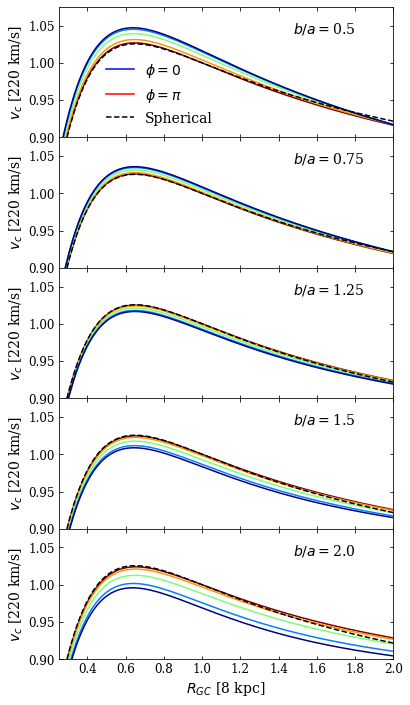

In [23]:
# Declare the range of c to explore
phi_range = np.linspace(0,np.pi/2,num=5)
b_range = np.array([0.5,0.75,1.25,1.5,2.0])

# Start the figure
fig = plt.figure(figsize=(6,12))
axs = fig.subplots(nrows=len(b_range), ncols=1)

for i in range(len(b_range)):
    
    plt.sca(axs[i])
    
    for j in range(len(phi_range)):
        
        # Declare the triaxial NFW
        tripot_halo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                                     a=mwhalo.a,
                                                     b=b_range[i],
                                                     c=1.0,
                                                     normalize=0.35)
        tripot = [tripot_halo,mwbulge,mwdisk]
    
        # Plot the rotation curve
        norm_val = (np.max(phi_range)-phi_range[j])/(np.max(phi_range)-np.min(phi_range))
        potential.plotRotcurve(tripot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=phi_range[j], 
                               color=cmap(norm_val))
    ###j
    
    potential.plotRotcurve(mwpot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color='Black', 
                           linestyle='dashed')
    
    axs[i].set_xlim(0.25,2.0)
    axs[i].set_ylim(0.9,1.075)
    axs[i].annotate(r'$b/a = $'+str(b_range[i]), (0.7,0.8), xycoords='axes fraction', fontsize=14)
    axs[i].tick_params(direction='in', top='on', right='on', labelbottom='off', labelsize=12)
    axs[i].set_ylabel(r'$v_{c}$ [220 km/s]', fontsize=14)
###i

axs[0].plot([], [], c='Blue', label=r'$\phi=0$')
axs[0].plot([], [], c='Red', label=r'$\phi=\pi$')
axs[0].plot([], [], c='Black', linestyle='dashed', label=r'Spherical')
leg = axs[0].legend(loc=(0.125,0.05), frameon=False, fontsize=14)
axs[-1].set_xlabel(r'$R_{GC}$ [8 kpc]', fontsize=14)
axs[-1].tick_params(labelbottom='on')

fig.subplots_adjust(hspace=0)
fig.savefig('plots/tripot_bphi.pdf')
plt.show()
plt.close('all')

### Now try doing Dehnen growth

In [8]:
# Scalp potential parameters for physical implementation
mwhalo_a = mwhalo.a * mwhalo._ro * apu.kpc
mwhalo_amp = mwhalo.dens(mwhalo_a,0) * 16 * mwhalo.a**3 * np.pi * \
             gpconv.mass_in_msol(mwhalo._vo, mwhalo._ro) * apu.M_sun

mwdisk_a = mwdisk._a * mwdisk._ro * apu.kpc
mwdisk_b = mwdisk._b * mwdisk._ro * apu.kpc
mwdisk_amp = mwdisk._amp * gpconv.mass_in_msol(mwdisk._vo, mwdisk._ro) * apu.M_sun

mwbulge_r1 = 1
mwbulge_amp = mwbulge.dens(mwbulge_r1,0) * np.exp((1/mwbulge.rc)**2) * \
              gpconv.dens_in_msolpc3(mwhalo._vo, mwhalo._ro) * apu.M_sun / apu.pc**3 
mwbulge_alpha = mwbulge.alpha
mwbulge_rc = mwbulge.rc * mwbulge._ro * apu.kpc

In [9]:
# Generate the scalped potentials
mwbulge_scal = potential.PowerSphericalPotentialwCutoff(amp=mwbulge_amp, alpha=mwbulge_alpha, rc=mwbulge_rc)
mwbulge_scal.turn_physical_off()
mwdisk_scal = potential.MiyamotoNagaiPotential(amp=mwdisk_amp, a=mwdisk_a, b=mwdisk_b)
mwdisk_scal.turn_physical_off()
mwhalo_scal = potential.NFWPotential(amp=mwhalo_amp, a=mwhalo_a)
mwhalo_scal.turn_physical_off()

mwpot_scal = [mwhalo_scal, mwdisk_scal, mwbulge_scal]

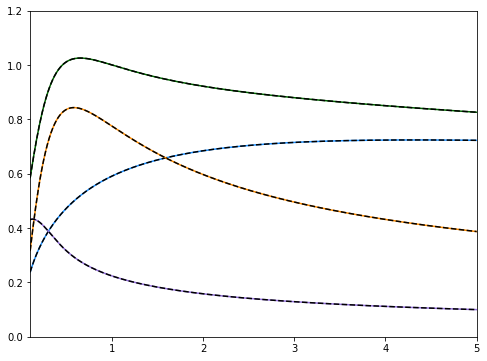

In [10]:
# Check the rotation curve.

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

mwhalo_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DodgerBlue')
mwhalo.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
mwdisk_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DarkOrange')
mwdisk.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
mwbulge_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='MediumPurple')
mwbulge.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
potential.plotRotcurve(mwpot_scal, Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DarkGreen')
potential.plotRotcurve(mwpot, Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')

ax.set_xlim(0.1,5)
ax.set_ylim(0,1.2)
plt.show()

In [175]:
# Make the triaxial halo
trihalo_scal = potential.TriaxialNFWPotential(amp=mwhalo_amp,
                                             a=mwhalo_a,
                                             b=2.0,
                                             c=1.0)
trihalo_scal.turn_physical_off()

# Make the negative amplitude NFW
mwhalo_scal_rev = potential.NFWPotential(amp=mwhalo_amp*-1,
                                    a=mwhalo_a)
mwhalo_scal_rev.turn_physical_off()

# Wrap the potentials in the Dehnen Smooth wrapper
# One is the triaxial NFW, which grows. Another is the MWPotential2014 NWF, which grows negatively in time.
# Finally wrap with the MWPotential2014 halo, which is constant, and will cancel out the negatively growing 
# MWPotential2014 halo when it is fully grown, leaving the triaxial halo
trihalo_scal_dsw = potential.DehnenSmoothWrapperPotential(pot=trihalo_scal, tform=-9.*apu.Gyr, tsteady=8.*apu.Gyr)
trihalo_scal_dsw.turn_physical_off()
mwhalo_scal_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo_scal_rev, tform=-9.*apu.Gyr, tsteady=8.*apu.Gyr)
mwhalo_scal_rev_dsw.turn_physical_off()

# All together
tripot_grow = [mwhalo_scal_rev_dsw, 
               mwhalo_scal, 
               trihalo_scal_dsw, 
               mwdisk_scal, 
               mwbulge_scal]

In [176]:
# Declare the orbit and integrate

o = orbit.Orbit(vxvv=[8.*apu.kpc, 
                      0.*apu.km/apu.s, 
                      -220.*apu.km/apu.s, 
                      0.*apu.radian])

times = np.linspace(-0,-10,num=1000)*apu.Gyr
o.integrate(times, tripot_grow)

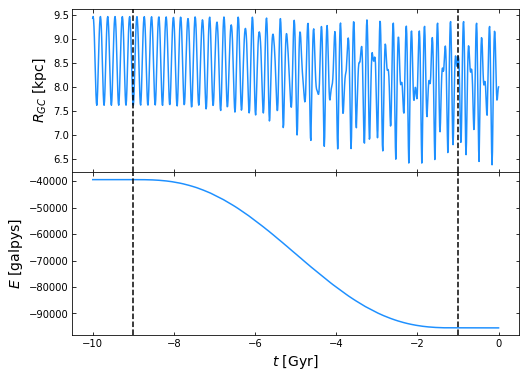

In [178]:
# Start the figures
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot( times, o.R(times), color='DodgerBlue')
# ax1.set_xlabel(r'$t$ [Gyr]', fontsize=14)
ax1.set_ylabel(r'$R_{GC}$ [kpc]', fontsize=14)
ax1.axvline(-1, color='Black', linestyle='dashed')
ax1.axvline(-9, color='Black', linestyle='dashed')
ax1.tick_params(direction='in', labelbottom='off', right='on', top='on')

ax2.plot( times, o.E(times), color='DodgerBlue')
ax2.set_ylabel(r'$E$ [galpys]', fontsize=14)
ax2.set_xlabel(r'$t$ [Gyr]', fontsize=14)
ax2.axvline(-1, color='Black', linestyle='dashed')
ax2.axvline(-9, color='Black', linestyle='dashed')
ax2.tick_params(direction='in', right='on', top='on')

fig.subplots_adjust(hspace=0)
fig.savefig('plots/tripot_growhalo.pdf')
plt.show()
plt.close('all')

Shows that the orbit becomes perturbed with the introduction of the triaxial halo, and that the energy only changes when the halo is changed, but not before or after

# Distribution function time

In [184]:
# Set the velocity dispersions in km/s
sigma_vR = 46
sigma_vT = 40
sigma_vZ = 28

# Make the quasi-isothermal distribution function. See notebook #3 for the velocity scales.
qdf_aA= actionAngleAdiabatic(pot= potential.MWPotential2014,c=True)
qdf = df.quasiisothermaldf(hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

In [ ]:
## Make the halo parameter arrays

# Make a 1-D grid of halo values to test.
phi_range = np.linspace(0, np.pi/2, 5)

# The times over which each orbit will be integrated
times = -np.array([0,10]) * apu.Gyr

In [185]:
# Now make the grid for our velocities, which will span 2sigma in each of R,T,Z velocities
vR_range = np.arange( -2*sigma_vR, 2*sigma_vR+1, 10. )
vT_range = np.arange( -2*sigma_vT, 2*sigma_vT+1, 10. )+210 # Plus rotational velocity minus 10 for Assym. Drift.

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(phi_vals),len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

# delta_vR = np.diff(vR_range)[0]
# delta_vT = np.diff(vT_range)[0]

print( str(len(vR_range)*len(vT_range)) )
print('Delta vR = '+str(np.diff(vR_range)[0]))
print('Delta vT = '+str(np.diff(vT_range)[0]))

323
Delta vR = 10.0
Delta vT = 10.0


In [186]:
## Now loop over all of the orbit possibilities, evaluate them in a triaxial NFW which evolves backwards to 
## become a smooth NFW

# Timing
ot_total = 0
oit_total = 0
dft_total = 0

tot_start = time.time()

for i in range( len(phi_range) )

    # Make the halo for this parameter
    
    
    for j in range( len(vR_range) ):
        for j in range( len(vT_range) ):
        
        # Make the orbit
        ot_start = time.time()
        o = orbit.Orbit(vxvv=[8.*apu.kpc, 
                              vR_range[i]*apu.km/apu.s, 
                              vT_range[j]*apu.km/apu.s, 
                              0.*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])
        df0[i,j] = ddf(o).value
        
        ot_end = time.time()
        oit_start = time.time()
        o.integrate(times, tripot_grow)
        oit_end = time.time()
        
        # Now evaluate the distribution function of the old orbit.
        dft_start = time.time()
        dfp[i,j] = qdf(o(times[1]))
        dft_end = time.time()
        
        ot_total += (ot_end-ot_start)
        oit_total += (oit_end-oit_start)
        dft_total += (dft_end-dft_start)
        
tott_end = time.time()

# Display timing statistics
print('Took '+str(round(tott_end-tott_start,2))+' s total')
print('Orbit initialization took '+str(round(ot_total,2))+' s')
print('Orbit integration took '+str(round(oit_total,2))+' s')
print('DF evaluation took '+str(round(dft_total,2))+' s')

Took 88.63 s total
Orbit initialization took 0.44 s
Orbit integration took 87.56 s
DF evaluation took 0.62 s


In [188]:
# Compute the moments of the distribution function
df0_save = df0
dfp_save = dfp

dens0 = np.sum(df0) * delta_vR * delta_vT # Units of 1/kpc**2
densp = np.sum(dfp) * delta_vR * delta_vT # Units of 1/kpc**2

vR_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=1) * vR_range ) * delta_vR * delta_vT
vT_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=0) * vT_range ) * delta_vR * delta_vT
vR_avgp = (1/densp) * np.sum( np.sum(dfp, axis=1) * vR_range ) * delta_vR * delta_vT
vT_avgp = (1/densp) * np.sum( np.sum(dfp, axis=0) * vT_range ) * delta_vR * delta_vT

print('Average vR0: '+str(vR_avg0))
print('Average vT0: '+str(vT_avg0))
print('Average vR perturbed: '+str(vR_avgp))
print('Average vR perturbed: '+str(vT_avgp))

Average vR0: -0.3393577383642211
Average vT0: 200.34573505392873
Average vR perturbed: -0.8810439146837079
Average vR perturbed: 187.66172301697267


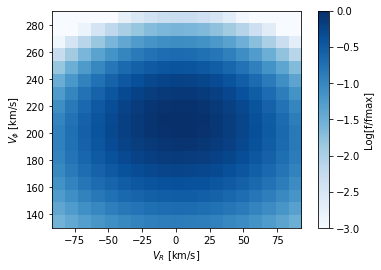

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Rotate to account for histogram -> plotting grid
intimg = np.rot90( df0/np.max(df0) )

img = ax.imshow(np.log10(intimg), interpolation='nearest',
                extent=[-2*sigma_vR, 2*sigma_vR+1, 210-2*sigma_vT, 210+2*sigma_vT+1],
               cmap='Blues', vmax=0, vmin=-3)

cbar = plt.colorbar(img)

ax.set_xlabel(r'$V_{R}$ [km/s]')
ax.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar.set_label('Log[f/fmax]')

plt.show()
fig.savefig('plots/zero-point_df.pdf')
plt.close(fig)


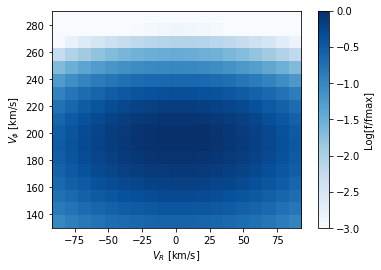

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Rotate to account for histogram -> plotting grid
intimg = np.rot90( dfp/np.max(dfp) )

img = ax.imshow(np.log10(intimg), interpolation='nearest',
                extent=[-2*sigma_vR, 2*sigma_vR+1, 210-2*sigma_vT, 210+2*sigma_vT+1],
               cmap='Blues', vmax=-3, vmin=0)

cbar = plt.colorbar(img)

ax.set_xlabel(r'$V_{R}$ [km/s]')
ax.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar.set_label('Log[f/fmax]')

plt.show()
fig.savefig('plots/perturbed_df.pdf')
plt.close(fig)

## Do something in the outter halo

In [191]:
# Now make the grid for our velocities, which will span 2sigma in each of R,T,Z velocities
vR_range = np.arange( -2*sigma_vR, 2*sigma_vR+1, 10. )
vT_range = np.arange( -2*sigma_vT, 2*sigma_vT+1, 10. )+200 # Plus rotational velocity.
# vZ_range = np.arange( -sigma_vZ, sigma_vZ+1, 1.0 )
# This goes along with a grid of distribution function values
dfp = np.zeros((len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

delta_vR = np.diff(vR_range)[0]
delta_vT = np.diff(vT_range)[0]

print( str(len(vR_range)*len(vT_range)) )
print('Delta vR = '+str(np.diff(vR_range)[0]))
print('Delta vT = '+str(np.diff(vT_range)[0]))

323
Delta vR = 10.0
Delta vT = 10.0


In [192]:
# Now loop over all of the orbit possibilities, evaluate them in a triaxial NFW which evolves backwards to 
# become a smooth NFW

times = -np.array([0,10]) * apu.Gyr

ot_total = 0
oit_total = 0
dft_total = 0

tott_start = time.time()
for i in range( len(vR_range) ):
    
    for j in range( len(vT_range) ):
        
        # Make the orbit
        ot_start = time.time()
        ot_start = time.time()
        o = orbit.Orbit(vxvv=[16.*apu.kpc, 
                              vR_range[i]*apu.km/apu.s, 
                              vT_range[j]*apu.km/apu.s, 
                              0.*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])
        df0[i,j] = ddf(o).value
        
        ot_end = time.time()
        oit_start = time.time()
        o.integrate(times, tripot_grow)
        oit_end = time.time()
        
        # Now evaluate the distribution function of the old orbit.
        dft_start = time.time()
        dfp[i,j] = qdf(o(times[1]))
        dft_end = time.time()
        
        ot_total += (ot_end-ot_start)
        oit_total += (oit_end-oit_start)
        dft_total += (dft_end-dft_start)
        
tott_end = time.time()

# Display timing statistics
print('Took '+str(round(tott_end-tott_start,2))+' s total')
print('Orbit initialization took '+str(round(ot_total,2))+' s')
print('Orbit integration took '+str(round(oit_total,2))+' s')
print('DF evaluation took '+str(round(dft_total,2))+' s')

Took 90.31 s total
Orbit initialization took 0.51 s
Orbit integration took 89.09 s
DF evaluation took 0.71 s


In [193]:
# Compute the moments of the distribution function
df0_save = df0
dfp_save = dfp

dens0 = np.sum(df0) * delta_vR * delta_vT # Units of 1/kpc**2
densp = np.sum(dfp) * delta_vR * delta_vT # Units of 1/kpc**2

vR_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=1) * vR_range ) * delta_vR * delta_vT
vT_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=0) * vT_range ) * delta_vR * delta_vT
vR_avgp = (1/densp) * np.sum( np.sum(dfp, axis=1) * vR_range ) * delta_vR * delta_vT
vT_avgp = (1/densp) * np.sum( np.sum(dfp, axis=0) * vT_range ) * delta_vR * delta_vT

print('Average vR0: '+str(vR_avg0))
print('Average vT0: '+str(vT_avg0))
print('Average vR perturbed: '+str(vR_avgp))
print('Average vR perturbed: '+str(vT_avgp))

Average vR0: -0.00011479060682270204
Average vT0: 209.22778326824442
Average vR perturbed: -0.17131836757523616
Average vR perturbed: 180.26528580752392


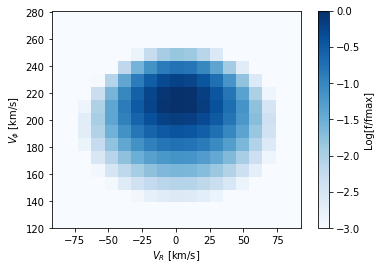

In [194]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Rotate to account for histogram -> plotting grid
intimg = np.rot90( df0/np.max(df0) )

img = ax.imshow(np.log10(intimg), interpolation='nearest',
                extent=[-2*sigma_vR, 2*sigma_vR+1, 200-2*sigma_vT, 200+2*sigma_vT+1],
               cmap='Blues', vmax=0, vmin=-3)

cbar = plt.colorbar(img)

ax.set_xlabel(r'$V_{R}$ [km/s]')
ax.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar.set_label('Log[f/fmax]')

plt.show()
fig.savefig('plots/zero-point_df.pdf')
plt.close(fig)

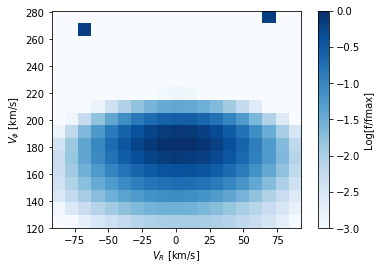

In [195]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Rotate to account for histogram -> plotting grid
intimg = np.rot90( dfp/np.max(dfp) )

img = ax.imshow(np.log10(intimg), interpolation='nearest',
                extent=[-2*sigma_vR, 2*sigma_vR+1, 200-2*sigma_vT, 200+2*sigma_vT+1],
               cmap='Blues', vmax=-3, vmin=0)

cbar = plt.colorbar(img)

ax.set_xlabel(r'$V_{R}$ [km/s]')
ax.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar.set_label('Log[f/fmax]')

plt.show()
fig.savefig('plots/perturbed_df.pdf')
plt.close(fig)